In [3]:
from pathlib import Path
from typing import List
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
)
from sklearn.preprocessing import StandardScaler

In [4]:
# simple Transformer-based classifier for sequence data
class TransformerClassifier(nn.Module):

    def __init__(
        self,
        input_size: int = 1,      # number of features per time step, 1 as we have 12 features so not much to process
        seq_length: int = 12,     # length of input sequences, covers all the 12 features
        d_model: int = 64,        # size of embedding vector, kept relatively small for speed
        nhead: int = 4,           # number of attention heads, kept small for speed
        num_layers: int = 2,      # number of Transformer layers, kept small for speed
        dropout: float = 0.3,     # dropout rate for regularisation, set 0.3 to reduce overfitting
    ):
        super().__init__()

        # project input features to model dimension
        self.input_projection = nn.Linear(input_size, d_model)

        # one encoder layer: self-attention + feed-forward
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )

        # stack the two encoder layers
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

        # final classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_projection(x)
        x = self.encoder(x)
        pooled = x.mean(dim=1) # mean pooling over the sequence length as suggested by ChatGPT
        return torch.sigmoid(self.classifier(pooled)).squeeze()


In [5]:
# wrap the features (X) and labels (y) into a DataLoader for batching
def _to_loader(X, y, batch_size: int, shuffle: bool = False):
    dataset = list(zip(X, y))  
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# train the model for one epoch at a time 
def train_one_epoch(model, loader, criterion, optim):
    model.train()  
    running = 0.0  
    
    for xb, yb in loader:  
        optim.zero_grad()  
        loss = criterion(model(xb), yb)  
        loss.backward()  
        optim.step()  
        running += loss.item() * xb.size(0)  

    return running / len(loader.dataset)

# Evaluate the model's accuracy
def evaluate(model, loader):
    model.eval()  
    correct = 0

    with torch.no_grad():  
        for xb, yb in loader:
            preds = (model(xb) >= 0.5).float()  
            correct += (preds == yb).sum().item()  
    return correct / len(loader.dataset)  

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
%matplotlib inline
# manually perform the cross-validation using custom k-folds in the DataFrame
def cross_validate_manual(
    Syn_df: pd.DataFrame,
    feature_columns: List[str],     
    epochs: int = 20,
    batch_size: int = 64,
    lr: float = 3e-4,            
    weight_decay: float = 1e-3,  
):
    results = []  # store best validation accuracy for each fold
    oof_true, oof_score = [], []        # collectors for out‑of‑fold predictions

    # loop through each unique fold number
    for fold in sorted(Syn_df["Fold"].unique()):
        print(f"\n── Fold {fold + 1} / {Syn_df['Fold'].nunique()} ────────────────")
        # split into both training and validation sets
        train_df = Syn_df[Syn_df["Fold"] != fold]
        validate_df = Syn_df[Syn_df["Fold"] == fold]

        # normalize features here and then reshape for the model input
        standard_scaler = StandardScaler()
        X_train = standard_scaler.fit_transform(train_df[feature_columns]).reshape(-1, 12, 1)
        X_validate = standard_scaler.transform(validate_df[feature_columns]).reshape(-1, 12, 1)

        # convert to PyTorch tensors
        y_train = train_df["Label"].values.astype(np.float32)
        y_validate = validate_df["Label"].values.astype(np.float32)
        X_train_ten = torch.tensor(X_train, dtype=torch.float32, device=device)
        y_train_ten = torch.tensor(y_train, device=device)
        X_val_ten = torch.tensor(X_validate, dtype=torch.float32, device=device)
        y_val_ten = torch.tensor(y_validate, device=device)
           
        
        # create the dataLoaders
        train_loader = _to_loader(X_train_ten, y_train_ten, batch_size, shuffle=True)
        val_loader = _to_loader(X_val_ten, y_val_ten, batch_size)

        # initialize model, loss, and optimizer
        transformer_model = TransformerClassifier().to(device)  # move model to GPU if available
        criterion = nn.BCELoss()  # binary classification loss
        optim = torch.optim.AdamW(transformer_model.parameters(), lr=lr, weight_decay=weight_decay)

        best_accuracy = 0.0
        inaccurate_epochs = 0
        patience = 5  # early stopping if no improvement for 'patience' epochs

        # training loop
        for epoch in range(1, epochs + 1):
            loss = train_one_epoch(transformer_model, train_loader, criterion, optim)
            val_acc = evaluate(transformer_model, val_loader)
            print(f"Epoch {epoch:02}/{epochs} - loss: {loss:.4f} - val acc: {val_acc:.4f}")

            # save the best model based on validation accuracy
            if val_acc > best_accuracy:
                best_accuracy, inaccurate_epochs = val_acc, 0
                best_state = transformer_model.state_dict()
            else:
                inaccurate_epochs += 1
                if inaccurate_epochs == patience:
                    print("Early stopping")
                    break
        # get the model predictions for the validation set
        transformer_model.eval()
        with torch.no_grad():
            y_prob = transformer_model(X_val_ten).cpu().numpy().ravel()
        oof_true.extend(y_validate.tolist())
        oof_score.extend(y_prob.tolist()) 
        
        # save the best accuracy for the fold
        results.append(best_accuracy)
       
        # save the best model checkpoint
        Path("checkpoints").mkdir(exist_ok=True)
        torch.save(best_state, f"checkpoints/fold_{fold}.pt")
        print(f"Best acc fold {fold + 1}: {best_accuracy:.4f}")

    # summary of the final results
    print("\n══════ Validation Accuracy Summary ══════")
    for i, acc in enumerate(results, 1):
        print(f"Fold {i}: {acc:.4f}")
    print(f"Mean Accuracy: {np.mean(results):.4f}")
    print(f"Standard Deviation: {np.std(results):.4f}")
    y_bin = (np.array(oof_score) > 0.5).astype(int)
    
    cm = confusion_matrix(oof_true, y_bin)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
    plt.title('Transformer Confusion Matrix')
    plt.show()


    fpr, tpr, _ = roc_curve(oof_true, oof_score)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr)).plot()
    plt.title('Transformer ROC')
    plt.show()
    
    prec, rec, _ = precision_recall_curve(oof_true, oof_score)
    PrecisionRecallDisplay(precision=prec, recall=rec).plot()
    plt.title('Transformer PR')
    plt.show()
    
         
    return results


── Fold 1 / 5 ────────────────
Epoch 01/20 - loss: 0.2189 - val acc: 0.9969
Epoch 02/20 - loss: 0.0452 - val acc: 0.9969
Epoch 03/20 - loss: 0.0372 - val acc: 0.9969
Epoch 04/20 - loss: 0.0336 - val acc: 0.9974
Epoch 05/20 - loss: 0.0283 - val acc: 0.9953
Epoch 06/20 - loss: 0.0260 - val acc: 0.9964
Epoch 07/20 - loss: 0.0237 - val acc: 0.9964
Epoch 08/20 - loss: 0.0238 - val acc: 0.9901
Epoch 09/20 - loss: 0.0244 - val acc: 0.9969
Early stopping
Best acc fold 1: 0.9974

── Fold 2 / 5 ────────────────
Epoch 01/20 - loss: 0.2515 - val acc: 0.9958
Epoch 02/20 - loss: 0.0450 - val acc: 0.9958
Epoch 03/20 - loss: 0.0371 - val acc: 0.9958
Epoch 04/20 - loss: 0.0286 - val acc: 0.9953
Epoch 05/20 - loss: 0.0268 - val acc: 0.9917
Epoch 06/20 - loss: 0.0223 - val acc: 0.9922
Early stopping
Best acc fold 2: 0.9958

── Fold 3 / 5 ────────────────
Epoch 01/20 - loss: 0.2029 - val acc: 0.9927
Epoch 02/20 - loss: 0.0402 - val acc: 0.9927
Epoch 03/20 - loss: 0.0315 - val acc: 0.9927
Epoch 04/20 - lo

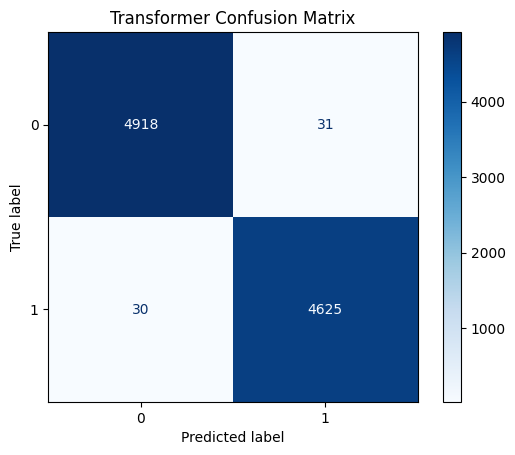

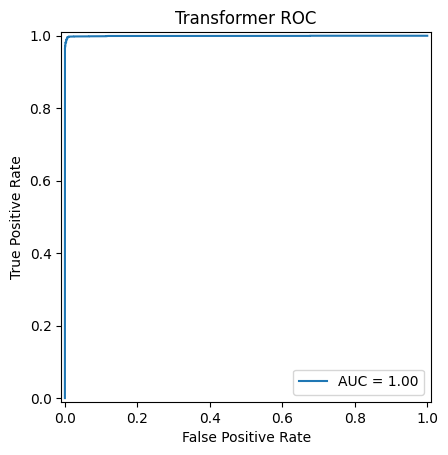

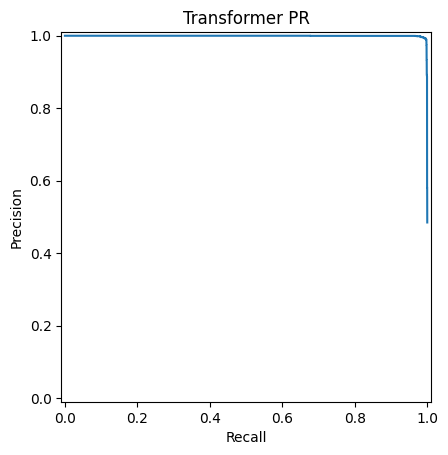


 Overall Training Stats 
Total Training Time: 141.70 seconds
Total RAM Usage Increase: 356.96 MB
CPU Usage (at final check): 4.4%
Per-fold accuracies       : ['0.9974', '0.9958', '0.9927', '0.9958', '0.9932']
Mean Accuracy             : 0.9950
Std-Dev                   : 0.0018


[NbConvertApp] Converting notebook d:\\Coding Projects\\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\\Taulant Matarova\\Transformer_model_2.ipynb to webpdf
[NbConvertApp] Building PDF
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 119433 bytes to d:\Coding Projects\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\Taulant Matarova\Transformer_model_2.pdf


In [7]:
import psutil, os, time, numpy as np, pandas as pd
process = psutil.Process(os.getpid())

# resource monitoring start point
overall_start_time = time.time()
overall_start_ram = process.memory_info().rss / 1024 / 1024  # in MB
overall_start_cpu = psutil.cpu_percent(interval=1)

# Load dataset
Syn_df = pd.read_csv("D:\\Coding Projects\\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\\Data\\K5_Dataset.csv")
feature_columns = Syn_df.columns.difference(["Label", "Fold"]).tolist()[:12]

# run cross-validation on Transformer
results = cross_validate_manual(Syn_df, feature_columns)

    
# end resource monitoring
overall_end_time = time.time()
overall_end_ram = process.memory_info().rss / 1024 / 1024  # in MB
overall_end_cpu = psutil.cpu_percent(interval=1)

# summary of training stats
print("\n Overall Training Stats ")
print(f"Total Training Time: {overall_end_time - overall_start_time:.2f} seconds")
print(f"Total RAM Usage Increase: {overall_end_ram - overall_start_ram:.2f} MB")
print(f"CPU Usage (at final check): {overall_end_cpu}%") 
print("Per-fold accuracies       :", [f"{x:.4f}" for x in results])
print(f"Mean Accuracy             : {np.mean(results):.4f}")
print(f"Std-Dev                   : {np.std(results):.4f}")

# save the notebook as a web PDF
os.getcwd()
!jupyter nbconvert --to webpdf "d:\\Coding Projects\\Detection-of-SYN-Flood-Attacks-Using-Machine-Learning-and-Deep-Learning-Techniques-with-Feature-Base\\Taulant Matarova\\Transformer_model_2.ipynb"